# Edge detection

first import the necessary modules

In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import convolve2d
import cv2

than we setup the loading path and display the image

In [3]:
img_liver_path = '../images/liver/liver_cirrhosis_1.png'
img_liver_healthy = cv2.imread(img_liver_path)
img_inverted = 255 - img_liver_healthy
img_gray = img_liver_healthy[:,:,0]

def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off') # we don't need an axis

create a kernel consisting of $n \times n$ ones and apply morphology closing to avoid noise.

In [4]:
closing_n = 80
kernel = np.ones((closing_n, closing_n), np.uint8)
inverted = 255 - img_liver_healthy
closing = cv2.morphologyEx(img_inverted, cv2.MORPH_CLOSE, kernel)

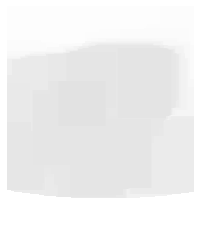

In [5]:
show_img(closing)

then apply the canny operator 
* gaussian blur
* gradient $G_x, G_y$ via sobel 
* gradient strength $\sqrt{G_x^2 + G_y^2}$ and direction $\arctan(\frac{G_y}{G_x})$
* non maximum supression, which removes pixels that should not be part of an edge
* last step is called Hysteresis, it uses two parameters (_upper_ and _lower_):
    - if pixel gradient higher than _upper_ $\rightarrow$ pixel accepted as edge 
    - if pixel gradient below _lower_ $\rightarrow$ pixel gets rejected
    - if pixel gradient between _lower_ and _upper_ $\rightarrow$ only accepted if pixel is connected to a pixel that is above _upper_

(Text(0.5, 1.0, 'only edges'), (-0.5, 327.5, 382.5, -0.5))

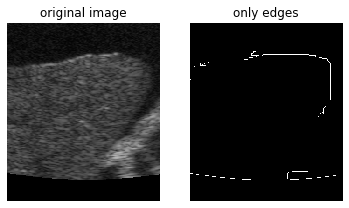

In [6]:
lower = 19
upper = 39
edges = cv2.Canny(closing, lower, upper)

plt.subplot(121), plt.imshow(img_liver_healthy, cmap='gray')
plt.title('original image'), plt.axis('off')
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('only edges'), plt.axis('off')

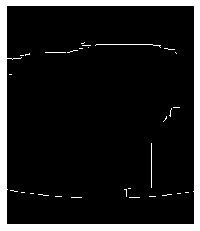

In [7]:
show_img(edges)

## testing stuff here

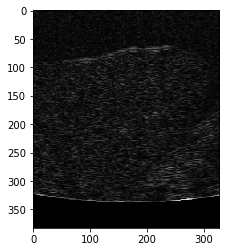

In [8]:
scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],
                   [-10+0j, 0+ 0j, +10 +0j],
                   [ -3+3j, 0+10j,  +3 +3j]])

grad = convolve2d(img_gray, scharr, boundary='symm', mode='same')
plt.imshow(np.absolute(grad), cmap='gray')

## Discrete fourier transform

from [here](https://akshaysin.github.io/fourier_transform.html) honestly no idea what its doing and results dont look to good to me. Maybe i am doing something wrong here.

In [9]:
dft = cv2.dft(np.float32(img_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

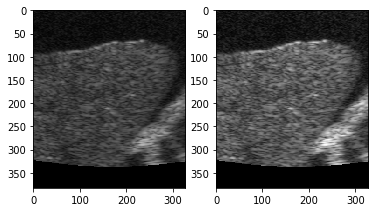

In [10]:
rows, cols = img_gray.shape
crow, ccol = int(rows / 2), int(cols / 2)  # center

# Circular HPF mask, center circle is 0, remaining all ones

mask = np.ones((rows, cols, 2), np.uint8)
r = 80
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 3 + (y - center[1]) ** 3 <= r*r
mask[mask_area] = 1

# apply mask and inverse DFT
fshift = dft_shift * mask

f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])


fig_dft, axs_dft = plt.subplots(nrows=1,ncols=2)
axs_dft[0].imshow(img_liver_healthy)
axs_dft[1].imshow(img_back, cmap='gray')

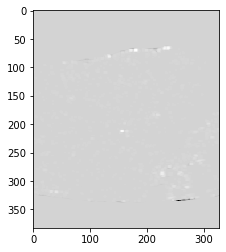

In [28]:
block_size = 4 # size of neighbourhood
ksize = 7 # aperture parameter of sobel 
k = 0.04 # free parameter
dst = cv2.cornerHarris(img_gray, block_size, ksize, k)
dst = cv2.dilate(dst, None)

plt.imshow(dst, cmap = 'gray')

array([[-3.2183067e-10,  7.4530874e-08,  4.5098471e-07, ...,
         4.2863642e-09,  4.2863642e-09,  4.2863642e-09],
       [ 5.6410592e-09,  7.4530874e-08,  4.7275762e-07, ...,
         4.2863642e-09,  4.2863642e-09,  4.2863642e-09],
       [ 5.6410592e-09,  9.3698482e-08,  4.7275762e-07, ...,
         1.6741882e-07,  2.6886422e-08,  2.6886422e-08],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)